## HIGH DIMENSIONAL ANALYSIS


*   **Programing Exercise: 01**
*   **Name: Đinh Anh Huy**
*   **Student code       : 18110103**




In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

#### Using the room temperature dataset in file room-temperature.csv:

Trong bộ dataset *room-temperature* này có 1 cột *Date* có dạng Time-Series. Để có thể thuận tiện cho việc giải quyết bài toán PCA cũng như trực quan hoá dữ liệu, ta chuyển kiểu dử liệu của cột *Date* từ *object* sang *TimeSeries*.

In [2]:
path = '/content/drive/MyDrive/Colab Notebooks/High-Dimentional Analysis/Lab01/room-temperature.csv'
data = pd.read_csv(path)
data.Date = pd.to_datetime(data.Date)
data.head()

,Date,FrontLeft,FrontRight,BackLeft,BackRight
0,2010-04-11 11:30:00,295.2,297.0,295.8,296.3
1,2010-04-11 12:00:00,296.2,296.4,296.2,296.3
2,2010-04-11 12:30:00,297.3,297.5,296.7,297.1
3,2010-04-11 13:00:00,295.9,296.7,297.4,297.0
4,2010-04-11 13:30:00,297.2,296.5,297.6,297.4


**(a) Plot a time series plot for each type of temperature data: FrontLeft, FrontRight, BackLeft, BackRight.**

In [3]:
data_temp = data.copy()
data_temp = data_temp.set_index('Date')

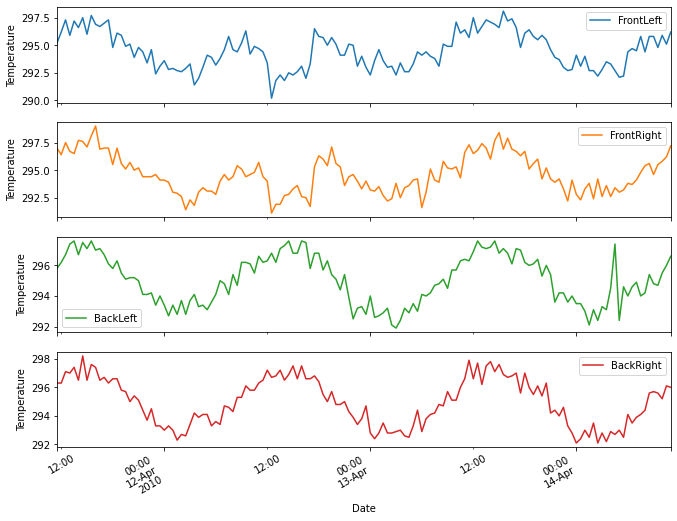

In [4]:
columns = data_temp.columns
axes = data_temp[columns].plot(figsize=(11,9), subplots=True)
for ax in axes:
  ax.set_ylabel('Temperature')

Từ các time series plot ở trên, ta thấy rằng cả 4 thành phần nhiệt độ có 2 dạng đường biểu thị chính. Trong đó, đối với thành phần *FrontLeft* và *FrontRight* có cùng dạng và 2 thành phần *BackLeft* và *BackRight* có cùng dạng. Có thể thấy rằng cùng một vị trí *Fronr* hoặc *Back* thì nhiệt độ bên *Left* hay *Right* chênh lệch không quá nhiều.

**(b) Implement the PCA algorithm to the whole dataset.**

Thuật toán PCA được thực hiện thông qua các bước:

1.   Chuẩn hoá dữ liệu (d-chiều).
2.   Xây dựng ma trận hiệp phương sai từ dữ liệu đã được chuẩn hoá.
3.   Tìm các vectơ riêng và trị riêng của ma trận hiệp phương sai.
4.   Xây dựng tập trực chuẩn từ tập hợp các vectơ riêng trên.
5.   Sắp xếp các trị riêng theo thứ tự giảm dần
6.   Chọn k vectơ riêng đầu tiên ứng với k trị riêng đầu tiên trong bộ trị riêng đã sắp xếp ở trên (k < d).
7.   Xây dựng ma trận chiếu $\textbf{W}\in M_{k\times d}(\mathbf{R})$ từ các vectơ riêng ở trên.
8.   Tìm hình chiếu $Y$ của ma trận dữ liệu X trong không gian mới sinh bởi ma trận $\textbf{W}$, $Y=\textbf{W}X$.

Từ ý tưởng các bước thực hiện như trên, ta xây dựng `class MyPCA` có

* *Tham số*:
  * `n_components`: Số lượng vectơ thành phần chính, mặc định là `None`.
* *Thuộc tính*:
  * `components_`: Danh sách các vectơ thành phần chính.
  * `explained_variance_ratio_`: Phần trăm phương sai được giải thích theo từng thành phần đã chọn. Tổng tất cả các tỷ lệ sẽ bằng 1.
  * `eigenpairs_`: Danh sách các bộ có thứ tự, trong đó mỗi bộ là 1 cặp (trị riêng, vectơ riêng tương ứng).
  * `weights_`: Ma trận chiếu $\textbf{W}$.
* *Phương thức*:
  * `fit(X)`: Áp dụng thuật toán PCA với X.
  * `fit_transform(X)`: Áp dụng thuật toán PCA với X và giảm số chiếu trên X.
  * `transform(X)`: Áp dụng giảm số chiều trên X với dữ liệu thu được từ phương thức `fit`.

  Input của các phương thức bắt buộc phải là dữ liệu dạng số.


In [5]:
class MyPCA:
  def __init__(self, n_components = None):
    self.n_components = n_components
    self.components_ = None
    self.explained_variance_ratio_ = []
    self.eigenpairs_ = None
    self.weights_ = None

  def fit(self, X):
    # Normalize data
    X_scaled = (X - X.mean(axis = 0))/X.std(axis = 0, ddof = 1)

    # Calculate covariance matrix of data
    cov_matrix = np.cov(X_scaled.T)

    # Eigendecomposition
    eigenvals, eigenvecs = np.linalg.eigh(cov_matrix)

    # Sort paires (eigenvalue, eigenvector) in descending order
    eigenpairs = [(abs(eigenval), eigenvec) for (eigenval, eigenvec) in zip(eigenvals, eigenvecs.T)]
    eigenpairs = sorted(eigenpairs, key = lambda pair: pair[0], reverse = True)

    # Select a subset from the rearranged Eigenvalues vector
    # If n_components is None, select all. Otherwise, select first n_components elements
    if self.n_components is None:
        self.eigenpairs_ = eigenpairs
    else:
        self.eigenpairs_ = eigenpairs[:self.n_components]

    # Construct weight matrix from above subset
    self.components_ = [eigenvec for (_, eigenvec) in self.eigenpairs_]
    n_eigenvals = [eigenval for (eigenval, _) in self.eigenpairs_]
    self.weights_ = np.array([eigenvec.T for eigenvec in self.components_])

    # Calculate percentage of cariance explained by each of the selected components
    for i in range(len(n_eigenvals)):
      self.explained_variance_ratio_.append(n_eigenvals[i]/np.sum(eigenvals))

  def transform(self, X):
    # Normalize data
    X_scaled = (X - X.mean(axis = 0))/X.std(axis = 0, ddof = 1)

    # Transform data    
    return self.weights_.dot(X_scaled.T).T

  def fit_transform(self, X):
    # Fit PCA algorithm to X
    self.fit(X)

    # Transform data
    return self.transform(X)

In [6]:
pca = MyPCA()
pca.fit(data_temp)
pca.explained_variance_ratio_

[0.766080095176909,
 0.16896714114532818,
 0.036686099850485744,
 0.028266663827277088]

**(c) After observing these time series plot in (a), how many latent variables should we use for the PCA algorithm to keep the most meaningful information? Apply the PCA for the temperature data by your chosen number of latent variables.**

Từ việc quan sát các biểu đồ time series ở câu (a), ta rút ra được có 2 dạng biểu đồ chính trong 4 thành phần nhiệt độ được vẽ. Do đó ta chọn số biến latent là **2** để có thể giữ hầu hết các thông tin có ý nghĩa. 

Hơn nữa, bằng việc sử dụng hàm `get_number_of_principal_components` để tìm ra số thành phần chính, thì ta thấy rằng với số biến latent là **2** thì ta có thể giữ lại đến 90% thông tin của dữ liệu. 

Bên cạnh đó, ta nhìn vào `explained_variance_ratio_` của các trị riêng thì có thế thấy rằng, thành phần thứ 1 có thể giữ đến hơn 76% thông tin và thành phần thứ 2 giữ được khoảng 16% thông tin, trong khi đó 2 thành phần còn lại tổng phần trăm thông tin được giữ lại ở trên 2 thành phần này chưa đến 10%. Do đó mà việc chọn số biến latern bằng **2** là hợp lý.

In [7]:
def get_number_of_principal_components(eigenpairs, threshold = 0.95):
  '''
      Find the number of principal components with specified threshold information that we want to keep 
      Parameters:
      -----------------------
          @eigenpairs: list-like
              Pairs (eigenvalue, eigenvector) from PCA 
          @threshold: float, default = 0.95
              The threshold information that we want to keep
      Return:
      -----------------------
          Number of principal components.
  '''
  # Get eigenvalues from eigenpairs
  eigenvals = [eigenval for (eigenval, _) in eigenpairs]
  eigenvals = np.array(eigenvals)
  # Calculate the cumulative sum of eigenvalues
  cumsum = np.cumsum(eigenvals)
  # Calculate percentage 
  cumsum /= cumsum[-1]
  # Loop in cumsum, return index + 1 if considered value in cumsum large or equal to threshold
  for i, val in enumerate(cumsum):
    if val >= threshold:
        return i + 1

In [8]:
get_number_of_principal_components(pca.eigenpairs_, threshold=0.90)

2

In [9]:
pca = MyPCA(n_components=2)
pca.fit_transform(data_temp)
pca.components_

[array([-0.49127375, -0.50211307, -0.49486494, -0.51150881]),
 array([ 0.5308801 ,  0.47235221, -0.53968805, -0.4514272 ])]

**So sánh với kết quả chạy bằng thư viên scikit-learn.**

In [10]:
# Normalize data
X = data_temp.copy()
X_scaled = (X - X.mean(axis = 0))/X.std(axis = 0, ddof = 1)

# Implement PCA with scikit-learn library
from sklearn.decomposition import PCA
pca_skl = PCA(n_components=2)
X_pca_skl = pca_skl.fit_transform(X_scaled)
pca_skl.components_

array([[ 0.49127375,  0.50211307,  0.49486494,  0.51150881],
       [-0.5308801 , -0.47235221,  0.53968805,  0.4514272 ]])

Nhận xét thấy rằng các vecto thành phần chính chạy bằng hàm của thư viện scikit-learn cho ra kết quả khá giống với hàm tự xây dựng ở câu b. Điểm khác nhau là dấu của các vecto bị thay đổi, tuy nhiên điểm khác nhau này không có ảnh hưởng lớn nên có thể xem xét bỏ qua.